In [1]:
%matplotlib inline
import xarray as xr
import os
import numpy as np
import netCDF4
from netCDF4 import Dataset
import pandas as pd
import nc_time_axis 
import cftime
import pandas as pd

from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit 

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import proplot as pplt

import warnings
warnings.filterwarnings('ignore')

/data/softs/anaconda3-2020.07/envs/gloenv_py3.9/lib/python3.9/site-packages/pyproj/__init__.py:91: UserWarning: Valid PROJ data directory not found. Either set the path using the environmental variable PROJ_LIB or with `pyproj.datadir.set_data_dir`.
  warnings.warn(str(err))


# Data load in

In [2]:
# to set
r_sulfur =  ['12', 
             '13', 
             '14']
r_over =  ['1', 
           '2', 
           '3'
          ]
end_I = 2062
end_II = 2150
end_III = 2249

In [3]:
dir_NER = '..'
dir_hist = f'{dir_NER}historical/'
dir_piControl=f'{dir_NER}piControl/'
dir_sulfur = f'{dir_NER}ssp534-sulfur/'
dir_over = f'{dir_NER}ssp534-over/'

In [4]:
scens = ['ssp534-sulfur', 'ssp534-over']
params = ['fgco2', 'nbp']
nb_cs_params = len(params) 

In [5]:
#load in data
# turn from monthly mean to yearly average
# merge with historical data for smooth 10 year rolling mean
data = dict()
over=dict()
over_var=dict()
sulf=dict()
sulf_var=dict()
    
for exp in ['ssp126', 'ssp534-over', 'historical', 'ssp534-sulfur']:
    if exp == 'ssp534-over':
        ds =[]
        for i in range(0, nb_cs_params):
            for mem in r_over:
                over[f'{params[i]}_{mem}'] = xr.open_mfdataset(f'{dir_over}CNRM-ESM2-1_ssp534-over_r{mem}i1p1f2/merged/{params[i]}_*mon_CNRM-ESM2-1_{exp}_r{mem}i1p1f2_*_201501-224912.nc'
                                           , engine="netcdf4").groupby('time.year').mean('time')
            data[f'{params[i]}_{exp}'] = xr.concat([over[f'{params[i]}_1'], over[f'{params[i]}_2'], over[f'{params[i]}_3']], dim='member')#.mean('member')
        
    
# load in historic data to get smooth 10year rolling mean at the start of the future simulations
    elif exp == 'historical':
        ds =[]
        for i in range(0, nb_cs_params):
            data[f'{params[i]}_{exp}'] = xr.open_mfdataset(f'{dir_NER}historical/{params[i]}_*_g*_185001-201412.nc'
                                    , engine="netcdf4").drop('time_bounds').groupby('time.year').mean('time')

    elif exp == 'ssp534-sulfur':
        ds=[]
        for i in range(0, nb_cs_params):
            for mem in r_sulfur:
                sulf[f'{params[i]}_{mem}'] = xr.open_mfdataset(f'{dir_sulfur}CNRM-ESM2-1_ssp534-over_r{mem}i1p1f2*/merged/{params[i]}_*mon_CNRM-ESM2-1_{exp}_r{mem}i1p1f2_*_201501-224912.nc'
                                           , engine="netcdf4").groupby('time.year').mean('time')
            data[f'{params[i]}_{exp}'] = xr.concat([sulf[f'{params[i]}_12'], sulf[f'{params[i]}_13'], sulf[f'{params[i]}_14']], dim='member')#.mean('member')

        

In [6]:
# piControl

data['fgco2_piControl'] = xr.open_mfdataset(f'{dir_piControl}fgco2_Omon_*_g*_185001-234912.nc'
                                                             , engine="netcdf4").mean('time')
data['nbp_piControl'] = xr.open_mfdataset(f'{dir_piControl}nbp_Lmon_*_g*_185001-234912.nc'
                                                             , engine="netcdf4").mean('time')


# area data
areacello = xr.open_mfdataset(f'{archive}/CNRM_runs/areacello*.nc'
                                                             , engine="netcdf4")
areacella = xr.open_mfdataset(f'{archive}/CNRM_runs/areacella*.nc'
                                                             , engine="netcdf4")
sftlf =  xr.open_dataset(f'{scratch}/RE_analysis/LUC_file_IMAGE/sftlf_fx_CNRM-ESM2-1_historical_r2i1p1f2_gr.nc',
                                    engine="netcdf4")

In [7]:
# Add historical for smooth rolling mean
for scen in scens:
    for param in params:
        data[f'{param}_{scen}_long'] = xr.merge([data[f'{param}_{scen}'], data[f'{param}_historical']])

In [8]:
# this is the forcing file from the param file in ppm 
co2_cmip = pd.read_csv(f'{archive}/CNRM_runs/NER_analysis/GHG_CMIP6ssp534-over_2299_CO2_only.csv')

In [9]:
co2_cmip['year']= np.array(range(1850, 2299+1))

In [10]:
co2_short = co2_cmip[165:400]

In [11]:
# use the forcing file from the param file in ppm instead

co2_fut = xr.open_mfdataset(f'{dir_sulfur}CNRM-ESM2-1_ssp534-over_r12i1p1f2*/merged/co2_Amon_*_g*_201501-224912.nc'
                            , engine="netcdf4").groupby('time.year').mean('time')

# select surface pressure levels and convert to ppm
co2_ = co2_fut.sel(plev=slice(100000, 70000)).mean('plev').mean(('lat', 'lon')) * 1000000

In [12]:
# Calculate C sink in GtC/yr
land=dict()
ocean=dict()

for scen in scens:
    land[scen] = (areacella['areacella'].where(sftlf['sftlf']>50)*data[f'nbp_{scen}']*3600*365*24/1e12).sum(('lat', 'lon')).rolling(year=10).mean().sel(year=slice(2015,2249)).load()
    ocean[scen] = (areacello['areacello']*data[f'fgco2_{scen}']*3600*365*24/1e12).sum(('y', 'x')).rolling(year=10).mean().sel(year=slice(2015,2249)).load()

# Calc compatible emissions

In [14]:
######## Calculate CO2 growth rate

# subtract first year value from the rest of the timeseries
co2_short['CO2'] -= co2_short.iloc[0]['CO2']
co2_normalized = co2_short

co2_normalized_ = co2_['co2'] - co2_['co2'].sel(year=2015).values.item()

In [15]:
# extend shifted array with a 0 at the beginning and delete last element
co2_shift_array = co2_normalized['CO2'].to_numpy()
co2_shift_array_ext = np.insert(co2_shift_array,0,0)[:-1]

In [16]:
# diff between year x and x+1
co2_growth = co2_normalized['CO2'].to_numpy() - co2_shift_array_ext
# # turn co2 ppm into GtC
co2_growth_GtC = co2_growth * 2.124

###### add growth rate to Co2 dataset
# turn dataframe to xarray dataset
multi_index = co2_normalized.set_index(['year'])
co2_ds = multi_index.to_xarray()
# add growth rate as variable
co2_ds = co2_ds.assign(co2_growth=(['year'],co2_growth_GtC))

In [17]:
####### Compatible emissions
emi_FF = dict()
emi_FF_members = dict()


for scen in scens:
    emi_FF[scen] = (co2_ds['co2_growth'] + ocean[scen]['fgco2'].mean('member') + land[scen]['nbp'].mean('member')) *3.67
    emi_FF_members[scen] = (co2_ds['co2_growth'] + ocean[scen]['fgco2'] + land[scen]['nbp']) *3.67
    

In [18]:
diff_FF_members = emi_FF_members['ssp534-sulfur'] - emi_FF_members['ssp534-over']
diff_FF = emi_FF['ssp534-sulfur'] - emi_FF['ssp534-over']

#### Cumulative difference in the phases

In [19]:
cumulative_diff = diff_FF.cumsum()

In [21]:
phase_I = diff_FF.sel(year=slice(2015, end_I)).sum()
phase_II = diff_FF.sel(year=slice(end_I, end_II)).sum()
phase_III = diff_FF.sel(year=slice(end_II, end_III)).sum()
phase_all = phase_I + phase_II + phase_III

# CDR in ssp534-over
 from here: https://tntcat.iiasa.ac.at/SspDb/dsd?Action=htmlpage&page=about#v2

In [31]:
d = {"Time": [2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100], 
     "Total_CDR": [0, 0, 0.279, 3.050, 10.700, 17.300, 20.800, 21.900, 22.300, 22.500], # in GtCO2/yr
     "BECCS": [0.000, 0, 0.043300, 0.477, 2.020, 5.780, 10.200, 14.900, 19.400, 21.100], # in GtCO2/yr
     "Net_Emissions": [36.335, 39.549, 44.473, 43.522, 37.420, 28.454, 15.509, 2.748, -8.535, -13.600]} # in GtCO2/yr
df = pd.DataFrame(d)

In [32]:
d_extrap = {"Time": [2100,2110, 2120, 2130, 2140, 2150], 
     "Total_CDR": [22.500, 22.500, 22.500, 22.500, 22.500, 22.500]} # in GtCO2/yr
df_extrap = pd.DataFrame(d_extrap)

In [33]:
d_ = {"Time": [2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100], 
     "Total_CDR": [0, 0, 0.279, 3.050, 10.700, 17.300, 20.800, 21.900, 22.300, 22.500]} # in GtCO2/yr
df_ = pd.DataFrame(d_).cumsum()

In [34]:
d_cumsum = {"Time": [2100 ,2110, 2120, 2130, 2140, 2150], 
     "Total_CDR": [0, 22.500, 22.500, 22.500, 22.500, 22.500]} # in GtCO2/yr
df_cumsum = pd.DataFrame(d_cumsum).cumsum()

In [35]:
add_last = df_cumsum['Total_CDR'] + df_['Total_CDR'][9:10].item()

In [36]:
add_last

0    118.829
1    141.329
2    163.829
3    186.329
4    208.829
5    231.329
Name: Total_CDR, dtype: float64

In [37]:
d_all = {"Time": [2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100,2110, 2120, 2130, 2140, 2150], 
     "Total_CDR": [0, 0, 0.279, 3.050, 10.700, 17.300, 20.800, 21.900, 22.300, 22.500,22.500, 22.500, 22.500, 22.500, 22.500]} # in GtCO2/yr
df_all = pd.DataFrame(d_all)
df_all['Cum_CDR'] = df_all["Total_CDR"].cumsum()


In [38]:
df_all

,Time,Total_CDR,Cum_CDR
0,2010,0.000,0.000
1,2020,0.000,0.000
2,2030,0.279,0.279
3,2040,3.050,3.329
4,2050,10.700,14.029
5,2060,17.300,31.329
6,2070,20.800,52.129
7,2080,21.900,74.029
8,2090,22.300,96.329
9,2100,22.500,118.829


In [39]:
phase1_CDR = df_all.loc[df_all['Time'] == 2060]['Cum_CDR'].item()

In [40]:
phase2_CDR_ = df_all.loc[df_all['Time'] == 2150]['Cum_CDR'].item()
phase2_CDR = phase2_CDR_ - phase1_CDR

In [43]:
phase_all

<xarray.DataArray ()>
array(60.51627013)
Coordinates:
    depth    float64 0.0
    type     |S255 b'typeland'

# Plot

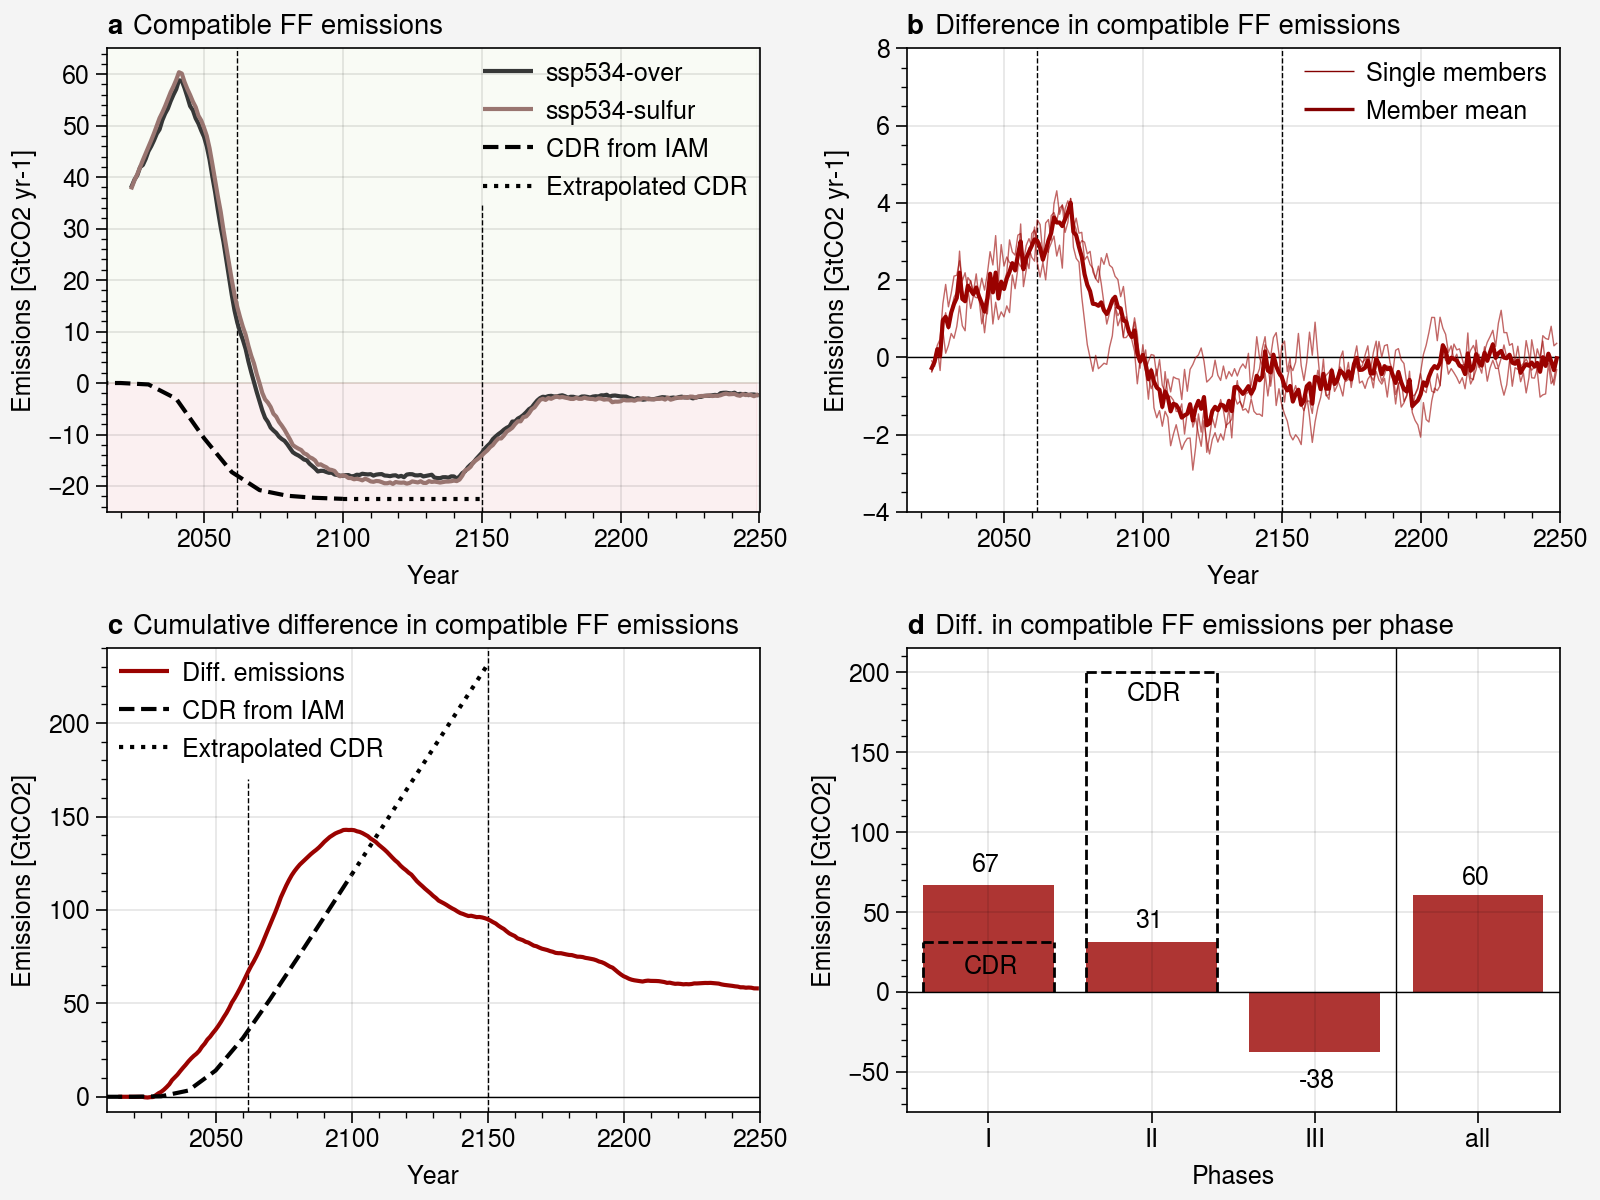

In [46]:
fig, axs = pplt.subplots(ncols=2, nrows=2, refwidth=1.7, figsize=(8, 6), sharey=False, sharex=False)


# FF emissions
axs[0].fill_between(list(range(2015, 2249+1)),0, 65, color='pale olive', alpha=0.08)
axs[0].fill_between(list(range(2015, 2249+1)),0, -25, color='faded red', alpha=0.08)

axs[0].plot(emi_FF['ssp534-over'].year,emi_FF['ssp534-over'], color='dark gray', label='ssp534-over')
axs[0].plot(emi_FF['ssp534-sulfur'].year,emi_FF['ssp534-sulfur'], color='red gray', label='ssp534-sulfur')
axs[0].plot(df['Time'], df['Total_CDR']*-1, color='black', label='CDR from IAM', ls='--')
axs[0].plot(df_extrap['Time'], df_extrap['Total_CDR']*-1, color='black', label='Extrapolated CDR', ls=':')

axs[0].vlines(2062,-25, 65, lw = 0.5, ls = '--', color='black')
axs[0].vlines(2150,-25, 35, lw = 0.5, ls = '--', color='black')
axs[0].legend(frameon=False, ncols=1)
axs[0].format(
    #abc=True, titleloc='l', #title='Region name',
    xlabel='Year', ylabel='Emissions [GtCO2 yr-1]', xlim=(2015, 2250),# ylim=(60.25, -20.25),
    title='Compatible FF emissions', titleloc='l'
)

# Difference
axs[1].hlines(0,2015, 2249+1, lw = 0.5, color='black')
axs[1].vlines(2062,-4, 8, lw = 0.5, ls = '--', color='black')
axs[1].vlines(2150,-4, 8, lw = 0.5, ls = '--', color='black')

axs[1].plot(diff_FF.year,diff_FF_members, color='deep red', lw=0.5, alpha=0.6)
axs[1].plot(diff_FF.year,diff_FF, color='deep red')
axs[1].format(
    #abc=True, titleloc='l', #title='Region name',
    xlabel='Year', ylabel='Emissions [GtCO2 yr-1]',
    title='Difference in compatible FF emissions', titleloc='l'
)

handles, labels = plt.gca().get_legend_handles_labels()

line1 = Line2D([0], [0], label='Single members', color='dark red', lw=0.5)
line2 = Line2D([0], [0], label='Member mean', color='dark red', lw=1.2)


#add handles
handles.extend([line1, line2])

#add legend
leg = axs[1].legend(handles=handles, ncol=1, frameon=False)



# Cumulative difference
axs[2].hlines(0,2015, 2249+1, lw = 0.5, color='black')
axs[2].vlines(2062,-8, 170, lw = 0.5, ls = '--', color='black')
axs[2].vlines(2150,-8, 240, lw = 0.5, ls = '--', color='black')

axs[2].plot(cumulative_diff.year,cumulative_diff, color='deep red', label='Diff. emissions')
axs[2].plot(df['Time'], df_['Total_CDR'], color='black', label='CDR from IAM', ls='--')
axs[2].plot(df_extrap['Time'], add_last, color='black', label='Extrapolated CDR', ls=':')

axs[2].format(
    #abc=True, titleloc='l', #title='Region name',
    xlabel='Year', ylabel='Emissions [GtCO2]',
    title='Cumulative difference in compatible FF emissions', titleloc='l'
)
axs[2].legend(frameon=False, ncols=1)


# Bar plot
#cycle = pplt.Cycle('plum', 'darkkhaki', 'grey', N=3, alpha=1)
cols = ['I', 'II', 'III','all']
data_ = [
    [phase_I],
    [phase_II],
    [phase_III],
    [phase_all]
]
axs[3].bar(cols, data_,  alpha=0.8, color='deep red')
axs[3].hlines(0,-0.5, 3.5, lw = 0.5, color='black')

axs[3].format(title='Diff. in compatible FF emissions per phase', titleloc='l', 
              xlabel='Phases', ylabel='Emissions [GtCO2]', 
              ylim=(-75,215)
             )
axs[3].text(-0.1,75,'67')
axs[3].text(0.9,40,'31')
axs[3].text(1.9,-60,'-38')
axs[3].text(2.9,67,'60')
axs[3].text(-0.15,11,'CDR')
axs[3].text(0.85,182,'CDR')

axs[3].vlines(2.5,-75, 215, lw = 0.5, ls = '-', color='black')

axs[3].hlines(phase1_CDR,-0.4,0.4, lw = 1, ls='--', color='black')
axs[3].vlines(0.4, 0,phase1_CDR, lw = 1, ls = '--', color='black')
axs[3].vlines(-0.4,0,phase1_CDR, lw = 1, ls = '--', color='black')

axs[3].hlines(phase2_CDR, 0.6, 1.4,lw = 1, ls='--', color='black')
axs[3].vlines(1.4,0, phase2_CDR, lw = 1, ls = '--', color='black')
axs[3].vlines(0.6,0, phase2_CDR, lw = 1, ls = '--', color='black')

fig.format(abc=True)

# save
save_name = f'Compat_FF_and_diff_figure.png'
save_dir = f'{scratch}/NER_analysis/plots/resubmission/' 
#pathlib.Path(save_dir).mkdir(parents=True, exist_ok=True) 
fig.savefig(save_dir + save_name, dpi=600)